In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.1.0'

In [3]:
import numpy as np

### Loading data

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [5]:
len(x_train)

60000

In [6]:
x_train.shape

(60000, 28, 28)

In [7]:
type(x_train[0])

numpy.ndarray

In [8]:
x_test.shape

(10000, 28, 28)

In [9]:
np.max(x_train)

255

In [10]:
np.min(x_train)

0

#### Exploring the labels

In [11]:
y_train.shape

(60000,)

In [12]:
type(y_train)

numpy.ndarray

In [13]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

    * data seems decently balanced

In [14]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009]))

### Visualization

In [15]:
import matplotlib.pyplot as plt

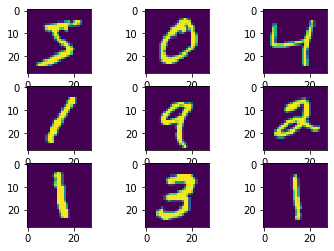

In [16]:
fig, ax = plt.subplots(3,3)
ax = ax.flatten()
for i,j in enumerate(ax):
    
    j.imshow(x_train[i])

### Preprocessing

In [17]:
x_train[0].shape

(28, 28)

In [18]:
x_train = x_train.reshape(-1, 28*28)
x_train.shape

(60000, 784)

In [19]:
x_test = x_test.reshape(-1, 28*28)

#### Scaling the image data

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
stdscaler = StandardScaler()

In [22]:
stdscaler_fit = stdscaler.fit(x_train)

In [23]:
x_train_scaled = stdscaler_fit.transform(x_train)
x_test_scaled = stdscaler_fit.transform(x_test)

In [24]:
x_train_scaled.dtype

dtype('float64')

In [25]:
x_train_scaled = x_train_scaled.astype(dtype = 'float32', copy=False)

In [26]:
x_train_scaled.dtype

dtype('float32')

In [27]:
x_test_scaled = x_test_scaled.astype(dtype = 'float32', copy=False)

In [28]:
np.max(x_train_scaled)

244.94693

In [29]:
np.min(x_train_scaled)

-1.274208

#### One-hot encoding of y

In [30]:
y_onehot_train = tf.keras.utils.to_categorical(y_train, num_classes=10, dtype='float32')

In [31]:
y_onehot_train.shape

(60000, 10)

In [32]:
# example
y_onehot_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [33]:
y_onehot_test = tf.keras.utils.to_categorical(y_test, num_classes=10, dtype='float32')

#### Creating validation data

In [34]:
from sklearn.utils import shuffle

In [35]:
# for reproducibility
random_seed = 100

In [36]:
x_train_scaled, y_onehot_train = shuffle(x_train_scaled, y_onehot_train, random_state = random_seed)

In [37]:
x_valid_scaled = x_train_scaled[:5000]
y_onehot_valid =  y_onehot_train[:5000]

In [38]:
x_train_scaled = x_train_scaled[5000:]
y_onehot_train =  y_onehot_train[5000:]

#### Creating tf.data.Datasets

In [39]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_scaled, y_onehot_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_scaled, y_onehot_test))
valid_dataset = tf.data.Dataset.from_tensor_slices((x_valid_scaled, y_onehot_valid))

In [40]:
minibatch = 60 # used in the paper

In [41]:
buffersize = len(y_train)
buffersize

60000

In [42]:
train_dataset = train_dataset.shuffle(buffer_size=buffersize, seed=random_seed,
                                     reshuffle_each_iteration=True).batch(minibatch, 
                                                                          drop_remainder = True).prefetch(buffer_size=
                                                                                                          tf.data.experimental.AUTOTUNE)

In [43]:
valid_dataset = valid_dataset.shuffle(buffer_size=buffersize, seed=random_seed, 
                                      reshuffle_each_iteration=False).batch(batch_size=minibatch).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.shuffle(buffer_size=buffersize, seed=random_seed, 
                                      reshuffle_each_iteration=False).batch(batch_size=minibatch).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [44]:
for i in test_dataset.take(1):
    print(i[1][0])

tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)


### Creating custom layers and keras model

    * 3 dense layers followed by 3 batch norm layers and a final dense layer with units equal to number of categories

#### Creating Custom Dense Layer

In [45]:
class dense_layer(tf.keras.layers.Layer):
    
    def __init__(self, units, **kwargs):
        
        super(dense_layer, self).__init__(**kwargs)
        self.units =  units
        
    def build(self, input_shape):
        
        self.kernel_weights = self.add_weight(name = 'weights', shape = (input_shape[-1], self.units), 
                                              dtype = self.dtype, initializer=tf.keras.initializers.Orthogonal(gain=1,seed=random_seed),
                                             trainable = self.trainable)
        self.bias = self.add_weight(name = 'bias', shape = (self.units,), dtype = self.dtype,
                                   initializer=tf.keras.initializers.zeros(), trainable = self.trainable)
        
    def call(self, inputs):
        
        return tf.add(tf.matmul(inputs, self.kernel_weights), self.bias)
    
    def get_config(self):
        
        config = super(dense_layer, self).get_config()
        config.update({'units': self.units})
        
        return config

##### *Testing*

In [46]:
x =  tf.reshape(tf.range(0,10, dtype = 'float32'), (2,5))
x

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[0., 1., 2., 3., 4.],
       [5., 6., 7., 8., 9.]], dtype=float32)>

In [47]:
testlayer = dense_layer(10, name = 'test', dtype = x.dtype, trainable = True)

In [48]:
testlayer(x)

<tf.Tensor: shape=(2, 10), dtype=float32, numpy=
array([[-0.39185402, -0.8637892 , -3.5154657 ,  0.6156957 ,  1.3804076 ,
         0.5214603 ,  0.07916665,  3.065235  ,  1.5912303 ,  1.5004475 ],
       [-0.7935976 ,  0.40243608, -8.864796  ,  3.0001144 ,  4.0484476 ,
        -3.460637  ,  1.753124  , 10.487197  ,  3.8650322 ,  3.2037134 ]],
      dtype=float32)>

In [49]:
testlayer.trainable_weights

[<tf.Variable 'test/weights:0' shape=(5, 10) dtype=float32, numpy=
 array([[ 0.46062446,  0.4805145 ,  0.27113432,  0.24228814,  0.03775417,
         -0.36714008,  0.31868806,  0.41027665,  0.03715476,  0.13125132],
        [-0.50286615,  0.16102067, -0.23385325,  0.2981111 ,  0.35705572,
         -0.46852738, -0.22770971,  0.17325218, -0.32941478, -0.20062807],
        [-0.3181508 , -0.21783853, -0.24576081, -0.13318287, -0.15441617,
         -0.34629565,  0.48582542,  0.16841805,  0.5900791 , -0.12977235],
        [ 0.37286136, -0.09267335, -0.65545404, -0.30528104, -0.15932733,
         -0.14040446, -0.30327463,  0.3746355 , -0.11272153,  0.19858865],
        [-0.09281758, -0.0777782 , -0.20593223,  0.37494838,  0.45254156,
          0.5259481 ,  0.06126237,  0.35781002,  0.26966286,  0.34121358]],
       dtype=float32)>,
 <tf.Variable 'test/bias:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>]

    * Variables can have the same name if they are of different shapes

In [50]:
testlayer.get_config()

{'name': 'test', 'trainable': True, 'dtype': 'float32', 'units': 10}

##### *End Testing*

#### Creating custom batch normalization layer

##### *Testing Population mean and variance implemented in the paper*

In [51]:
# Testing variance
x1 = np.random.randint(low = 0, high = 50, size = 12)
x2 = np.random.randint(low = 0, high = 50, size = 12)
x3 = np.random.randint(low = 0, high = 50, size = 12)

In [52]:
print(x1.mean(), x1.var())

25.5 209.08333333333334


In [53]:
print(x2.mean(), x2.var())

23.25 155.52083333333334


In [54]:
print(x3.mean(), x3.var())

23.5 191.41666666666666


In [55]:
np.hstack((x1, x2, x3))

array([24, 44, 44, 41, 31,  9,  9, 15, 45, 23, 16,  5, 26, 38, 24, 31,  3,
       49, 11, 10, 32, 22, 19, 14, 17,  0, 40, 33, 14, 22, 14, 37, 38, 31,
       36,  0])

In [56]:
# population mean
np.hstack((x1, x2, x3)).mean()

24.083333333333332

In [57]:
# population variance
np.hstack((x1, x2, x3)).var()

186.35416666666666

In [58]:
# variance from the paper
sum([x1.var(),x2.var(), x3.var()])/3*11/(12-1)

185.3402777777778

In [59]:
# mean from the paper
sum([x1.mean(),x2.mean(), x3.mean()])/3

24.083333333333332

* Using the moving mean and variance equation:

$\mu{_{mm}}$[B] = momentum*$\mu{_{mm}}$[B] + (1-momentum)*$\mu$[B]

In [60]:
testmm = 0
test_momntm = 0.9

for i in (x1, x2, x3):
    testmm = test_momntm*testmm +  (1-test_momntm)*(i.mean())
testmm

6.507999999999999

In [61]:
testvr = 0
test_momntm = 0.9

for i in (x1, x2, x3):
    testvr = test_momntm*testvr +  (1-test_momntm)*(i.var())
testvr

50.07429166666665

    * These are clearly wrong. Its obvious when one realizes that the moving mean initializer is zero.
      In searching for the definition, the above equation was returned for many hits

Reversing the weights

$\mu{_{mm}}$[B] = (1-momentum)*$\mu{_{mm}}$[B] + momentum*$\mu$[B]

In [62]:
testmm = 0
test_momntm = 0.9

for i in (x1, x2, x3):
    testmm = (1-test_momntm)*testmm +  test_momntm*(i.mean())
testmm

23.472

In [63]:
testvr = 0
test_momntm = 0.9

for i in (x1, x2, x3):
    testvr = (1-test_momntm)*testvr +  test_momntm*(i.var())
testvr

188.153625

    * Much closer to the population mean and variances

##### *End Testing*

##### *Testing*

In [64]:
x = tf.Variable([[1,2,3]], dtype = 'float32')
x

<tf.Variable 'Variable:0' shape=(1, 3) dtype=float32, numpy=array([[1., 2., 3.]], dtype=float32)>

In [65]:
offset = tf.Variable(0.001)

In [66]:
x + offset

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[1.001, 2.001, 3.001]], dtype=float32)>

In [67]:
(x + offset)*3/2

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[1.5015001, 3.0015   , 4.5015   ]], dtype=float32)>

In [68]:
btch = tf.Variable(10, dtype = 'int32')

In [69]:
(x+offset)/tf.cast(btch, offset.dtype)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.1001    , 0.20009999, 0.3001    ]], dtype=float32)>

In [70]:
x = tf.Variable(0, dtype = 'int32')

In [71]:
for i in range(5):
    x.assign_add(i)
print(x)

<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=10>


##### *End Testing*

### Custom BatchNorm layer

In [487]:
class custombn_paper(tf.keras.layers.Layer):
    
    """
    Not implementing momentum as defined in the keras BatchNorm layer
    
    Population mean and variance are calculated as defined in the paper
    
    This process can only be used when mini-batch size > 1
    
    """
    
    
    def __init__(self, stateful, **kwargs):
        
        super(custombn_paper, self).__init__(**kwargs)
        
        self.stateful = stateful
        # Without setting stateful, the Weights/Variables in the layers cannot be reset
        # model.reset_states()
        
        
#         self.batchsize = 60.0
    def build(self, input_shape):
        
#         self.inputshape = input_shape
        self.gamma = self.add_weight(name = 'scale', shape = (1, input_shape[-1]), initializer = tf.keras.initializers.ones(),
                                    trainable = self.trainable)
        self.beta = self.add_weight(name = 'shift', shape = (1,input_shape[-1]), initializer = tf.keras.initializers.zeros(),
                                   trainable = self.trainable)
        self.offset = tf.Variable(0.001, dtype = 'float32', trainable=False)
        
        self.moving_mean = self.add_weight(name = 'moving_mean', shape = (1, input_shape[-1]), initializer = tf.keras.initializers.Zeros(),
                                          trainable = False)
        self.moving_var =  self.add_weight(name = 'moving_var', shape = (1, input_shape[-1]), initializer = tf.keras.initializers.Zeros(),
                                          trainable = False)
        
        self.batch_count = tf.Variable(0, dtype = 'float32', name = 'batchcount', trainable=False)
        
        self.batchsize = tf.Variable(2, dtype = 'float32', name='batchsize', trainable=False)

        
        self.init_mm = self.moving_mean.read_value()
        self.init_mv = self.moving_var.read_value()
#         self.init_bc = self.batch_count.read_value()
#         self.init_bs = self.batchsize.read_value()
    
    def bn_training(self, inputs, axes = [0]):
        
#         self.batchsize = inputs.shape[0]
        
        
        tf.print('\nBatch size: ', self.batchsize)
        self.batch_mean, self.batch_var = tf.nn.moments(inputs, axes = axes, keepdims=True)
        
        self.moving_mean.assign_add(self.batch_mean)
        self.moving_var.assign_add(self.batch_var)


        # self.moving_var = self.moving_var + self.batch_var
        # doing this causes the object to transform into a constant tensor rather than a Variable or weight
       
        
        return tf.add(tf.multiply(tf.divide(tf.subtract(inputs, self.batch_mean), 
                                     tf.math.sqrt(tf.add(self.batch_var, self.offset))), self.gamma), self.beta)
    

    
    def update_mm_mv(self):
        """
        Updating mm and mv at the end of epoch
        """
        tf.print("\nIn update_mm_mv function")
        
        # self.batchsize = tf.cast(self.batchsize, tf.float32)
        # This is becoming None at the end of the last batch during training through bn_training
        # found by executing on_train_batch_end. This implies that bn_training is executed upon
        # execution of the last training batch. But why?

        
        self.moving_mean.assign(tf.cond(tf.greater(self.batch_count,0), 
                                        lambda: tf.divide(self.moving_mean,self.batch_count), lambda: self.moving_mean, name='update_mm'))
        
        self.moving_var.assign(tf.cond(tf.greater(self.batch_count,0), 
                                       lambda: tf.multiply(self.moving_var, tf.divide(self.batchsize, tf.multiply(tf.subtract(self.batchsize,1), self.batch_count))),
                                       lambda: self.moving_var, name='update_mv'))
        
    
    def bn_inference(self, inputs):
        

        # if self.batchsize == None:
        #     self.batchsize = 2    
        # This is required because during building the model, this function is also being evaluated
        # and giving "TypeError: unsupported operand type(s) for -: 'NoneType' and 'int' " because batchsize is None
#         @tf.function
#         def testprint(inpt):
#             tf.print(inpt)
              
        tf.print("\n I am in inference mode \n")
        tf.print("Moving mean: ", self.moving_mean[0,:5])
        
        return tf.add(tf.multiply(tf.divide(tf.subtract(inputs, self.moving_mean), 
                                     tf.math.sqrt(tf.add(self.moving_var, self.offset))), self.gamma), self.beta)
        
        
        
    def reset_states(self):
      
        # self.batch_count.assign(self.init_bc)
        self.moving_mean.assign(self.init_mm)
        self.moving_var.assign(self.init_mv)
        

#     def reset_running_values(self):
#         # input_shape = self.get_input_shape_at(0)
#         # Does work under Eager mode

#         self.moving_mean.assign(self.init_mm)
#         self.moving_var.assign(self.init_mv)
        
        
    def call(self, inputs, training):       
        
        return tf.cond(tf.equal(training, True, name='train_or_eval'),lambda: self.bn_training(inputs), lambda: self.bn_inference(inputs),
                      name = 'call_func') 


    def get_config(self):
        
        config = super(custombn_paper, self).get_config()
        config.update({'stateful': self.stateful})
        
        return config
        

##### *Testing*

In [73]:
tf.cast(False, tf.uint8)

<tf.Tensor: shape=(), dtype=uint8, numpy=0>

In [74]:
x = False
tf.equal(x, True)

<tf.Tensor: shape=(), dtype=bool, numpy=False>

In [75]:
x = tf.Variable(0.0)

In [76]:
temp = x.read_value()

In [77]:
x.assign(2)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=2.0>

In [78]:
x

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>

In [79]:
x.assign(temp)
x

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>

In [80]:
x.dtype

tf.float32

In [81]:
type(x)

tensorflow.python.ops.resource_variable_ops.ResourceVariable

In [82]:
y = None
type(y)

NoneType

In [83]:
type(y) == 'NoneType'

False

##### *End Testing*

In [84]:
def reset_graph():
    tf.keras.backend.clear_session()

In [104]:
reset_graph()

##### *Testing*

In [86]:
x = tf.reshape(tf.range(0,10, dtype='float32'), shape=(2,5))
x

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[0., 1., 2., 3., 4.],
       [5., 6., 7., 8., 9.]], dtype=float32)>

In [87]:
test_bnpaper = custombn_paper(True)

In [89]:
test_bnpaper(x, training = True)

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[-0.99992, -0.99992, -0.99992, -0.99992, -0.99992],
       [ 0.99992,  0.99992,  0.99992,  0.99992,  0.99992]], dtype=float32)>

In [90]:
test_bnpaper.weights

[<tf.Variable 'custombn_paper/scale:0' shape=(1, 5) dtype=float32, numpy=array([[1., 1., 1., 1., 1.]], dtype=float32)>,
 <tf.Variable 'custombn_paper/shift:0' shape=(1, 5) dtype=float32, numpy=array([[0., 0., 0., 0., 0.]], dtype=float32)>,
 <tf.Variable 'custombn_paper/Variable:0' shape=() dtype=float32, numpy=0.001>,
 <tf.Variable 'custombn_paper/moving_mean:0' shape=(1, 5) dtype=float32, numpy=array([[2.5, 3.5, 4.5, 5.5, 6.5]], dtype=float32)>,
 <tf.Variable 'custombn_paper/moving_var:0' shape=(1, 5) dtype=float32, numpy=array([[6.25, 6.25, 6.25, 6.25, 6.25]], dtype=float32)>,
 <tf.Variable 'custombn_paper/Variable:0' shape=() dtype=float32, numpy=1.0>,
 <tf.Variable 'custombn_paper/Variable:0' shape=() dtype=float32, numpy=2.0>]

In [91]:
test_bnpaper.reset_states()

In [92]:
test_bnpaper.weights

[<tf.Variable 'custombn_paper/scale:0' shape=(1, 5) dtype=float32, numpy=array([[1., 1., 1., 1., 1.]], dtype=float32)>,
 <tf.Variable 'custombn_paper/shift:0' shape=(1, 5) dtype=float32, numpy=array([[0., 0., 0., 0., 0.]], dtype=float32)>,
 <tf.Variable 'custombn_paper/Variable:0' shape=() dtype=float32, numpy=0.001>,
 <tf.Variable 'custombn_paper/moving_mean:0' shape=(1, 5) dtype=float32, numpy=array([[0., 0., 0., 0., 0.]], dtype=float32)>,
 <tf.Variable 'custombn_paper/moving_var:0' shape=(1, 5) dtype=float32, numpy=array([[0., 0., 0., 0., 0.]], dtype=float32)>,
 <tf.Variable 'custombn_paper/Variable:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'custombn_paper/Variable:0' shape=() dtype=float32, numpy=2.0>]

In [93]:
test_bnpaper.training = False

In [95]:
test_bnpaper(x, training = False)

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[  0.      ,  31.622774,  63.24555 ,  94.868324, 126.4911  ],
       [158.11388 , 189.73665 , 221.35942 , 252.9822  , 284.60498 ]],
      dtype=float32)>

In [96]:
tf.add(tf.multiply(tf.divide(tf.subtract(x, test_bnpaper.moving_mean), 
                                     tf.math.sqrt(tf.add(test_bnpaper.moving_var, test_bnpaper.offset))), test_bnpaper.gamma), test_bnpaper.beta)

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[  0.      ,  31.622774,  63.24555 ,  94.868324, 126.4911  ],
       [158.11388 , 189.73665 , 221.35942 , 252.9822  , 284.60498 ]],
      dtype=float32)>

    * Confirms

In [97]:
test_bnpaper.weights

[<tf.Variable 'custombn_paper/scale:0' shape=(1, 5) dtype=float32, numpy=array([[1., 1., 1., 1., 1.]], dtype=float32)>,
 <tf.Variable 'custombn_paper/shift:0' shape=(1, 5) dtype=float32, numpy=array([[0., 0., 0., 0., 0.]], dtype=float32)>,
 <tf.Variable 'custombn_paper/Variable:0' shape=() dtype=float32, numpy=0.001>,
 <tf.Variable 'custombn_paper/moving_mean:0' shape=(1, 5) dtype=float32, numpy=array([[0., 0., 0., 0., 0.]], dtype=float32)>,
 <tf.Variable 'custombn_paper/moving_var:0' shape=(1, 5) dtype=float32, numpy=array([[0., 0., 0., 0., 0.]], dtype=float32)>,
 <tf.Variable 'custombn_paper/Variable:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'custombn_paper/Variable:0' shape=() dtype=float32, numpy=2.0>]

In [98]:
test_bnpaper.reset_states()

    * custom defined same as keras defined

### Model fitting

In [488]:
def model_fitting_bnpaper(inputshape = [1], units1 = 100, units2 =100, units3=100, classes=10):
    
    input_lyr = tf.keras.Input(shape = inputshape, batch_size=None, name = 'input')
    
    dense1 = dense_layer(units = units1, name = 'dense1', trainable = True)(input_lyr)
    custombn1 = custombn_paper(stateful = True, name = 'bn1', trainable = True)(dense1)     
    activation1 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv1')(custombn1)
    
    dense2 = dense_layer(units = units2, name = 'dense2', trainable = True)(activation1)    
    custombn2 = custombn_paper(stateful = True, name = 'bn2', trainable = True)(dense2)     
    activation2 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv2')(custombn2)
    
    dense3 = dense_layer(units = units3, name = 'dense3', trainable = True)(activation2)    
    custombn3 = custombn_paper(stateful = True, name='bn3', trainable = True)(dense3)     
    activation3 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv3')(custombn3)
    
    
    output_lyr = dense_layer(units = classes, name='output') (activation3)
    # no softmax 
    
    return tf.keras.Model(inputs = [input_lyr], outputs = [output_lyr])

##### *Testing*

In [114]:
reset_graph()

In [101]:
x = (785,)

In [102]:
x[-1]

785

In [115]:
testmodel_hAPI = model_fitting_bnpaper(inputshape=(784,))

In [116]:
for layer in testmodel_hAPI.layers:
    
    if hasattr(layer, 'call'):
        if hasattr(layer.call, 'training'):
            print(layer)
    

In [117]:
for layer in testmodel_hAPI.layers:

    if getattr(layer, 'stateful', False):
        print(layer)

In [119]:
testmodel_hAPI.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
dense1 (dense_layer)         (None, 100)               78500     
_________________________________________________________________
custombn_paper (custombn_pap (None, 100)               403       
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dense2 (dense_layer)         (None, 100)               10100     
_________________________________________________________________
custombn_paper_1 (custombn_p (None, 100)               403       
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0     

In [120]:
for i in train_dataset.take(1):
    x = i[0][0:2]
    y = i[1][0:2]

In [121]:
x.shape

TensorShape([2, 784])

In [122]:
# Setting training = True
output1 =  testmodel_hAPI(x, training =True)

In [123]:
output1

<tf.Tensor: shape=(2, 10), dtype=float32, numpy=
array([[ 0.07456852,  0.3217428 ,  0.76883996, -0.56115365,  0.5446787 ,
        -0.7092006 , -0.08767772, -0.36047605, -1.1830816 , -1.3314551 ],
       [-0.07456852, -0.3217428 , -0.76883996,  0.56115365, -0.5446787 ,
         0.7092006 ,  0.08767772,  0.36047605,  1.1830816 ,  1.3314551 ]],
      dtype=float32)>

In [124]:
bn1 = testmodel_hAPI.layers[2]

In [125]:
bn1.moving_mean

<tf.Variable 'custombn_paper/moving_mean:0' shape=(1, 100) dtype=float32, numpy=
array([[-0.21910067, -0.04545818, -0.36881888, -0.35995263, -0.37876043,
         0.5636653 , -0.45316696,  0.41576093,  0.06434174, -0.13719991,
         0.7114807 ,  0.16890293, -0.26944566,  0.70864797,  1.1258295 ,
        -0.18561685, -0.47316995, -0.48458487, -0.47439256,  0.26698315,
        -0.06854546, -0.32742986, -0.7525749 ,  1.3198287 ,  0.04259807,
        -0.03536795,  0.6654351 , -0.3738553 ,  0.6054493 ,  0.90603566,
         0.76952225,  0.08472401, -0.6430973 ,  0.4030885 ,  0.85232085,
        -0.151348  ,  0.60588497, -0.08739981,  0.14842562, -0.11197841,
         0.08410388, -0.67636263,  1.1705109 , -0.26388553,  1.1846156 ,
        -0.1185993 ,  0.03499955,  0.5700469 , -1.1087158 ,  1.2339005 ,
         0.07632702, -0.5952873 , -0.17209323, -0.5292679 ,  0.5420853 ,
        -0.21385705,  1.1709832 ,  0.8948821 ,  0.05686894,  0.10488322,
        -0.5455679 , -0.01418075,  0.910839

In [126]:
bn1.moving_var

<tf.Variable 'custombn_paper/moving_var:0' shape=(1, 100) dtype=float32, numpy=
array([[1.11323716e-04, 8.17310363e-02, 1.31485581e-01, 1.64697424e-01,
        2.33810209e-02, 5.14779016e-02, 8.58729109e-02, 1.08998859e+00,
        3.23619954e-02, 4.93912309e-01, 9.71609354e-02, 1.28200173e-01,
        1.63687199e-01, 1.36766046e-01, 4.55434084e-01, 1.05486429e+00,
        1.49152905e-01, 9.58062485e-02, 9.18560982e-01, 2.37562522e-01,
        2.97709733e-01, 4.52963471e-01, 1.09890640e+00, 1.49301499e-01,
        4.33003455e-01, 4.59127419e-04, 1.29009755e-02, 6.23052620e-05,
        8.26743767e-02, 5.22027444e-03, 2.05745831e-01, 1.74092129e-01,
        9.75580215e-01, 9.36574787e-02, 1.11721694e+00, 5.12747467e-01,
        3.41698825e-01, 4.75322604e-02, 1.15777701e-01, 4.22812760e-01,
        8.27344894e-01, 6.81075752e-01, 1.96245368e-04, 1.25495404e-01,
        1.67617381e-01, 7.79511333e-01, 5.90005307e-04, 4.40345937e-03,
        9.27318633e-03, 3.53955209e-01, 4.33561280e-02, 

In [127]:
testmodel_hAPI.reset_states()

In [128]:
bn1.moving_mean

<tf.Variable 'custombn_paper/moving_mean:0' shape=(1, 100) dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [129]:
bn1.moving_var

<tf.Variable 'custombn_paper/moving_var:0' shape=(1, 100) dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [130]:
del testmodel_hAPI
reset_graph()
testmodel_hAPI = model_fitting_bnpaper(inputshape=(784,))

In [131]:
# Setting training = False
output1 =  testmodel_hAPI(x, training =False)

In [132]:
output1

<tf.Tensor: shape=(2, 10), dtype=float32, numpy=
array([[ 0.74668825,  1.2636757 , -0.08159411,  0.34712332, -0.19115561,
         0.2916773 , -0.13474743,  0.03781182, -0.7408727 , -1.3356284 ],
       [ 1.8295116 , -0.5051032 , -1.4750142 ,  0.04484307,  0.20471641,
         0.24860117, -1.1646487 ,  0.6938643 , -0.349613  ,  1.1323991 ]],
      dtype=float32)>

In [133]:
testmodel_hAPI.layers[2].moving_mean

<tf.Variable 'custombn_paper/moving_mean:0' shape=(1, 100) dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [134]:
tf.reduce_sum(testmodel_hAPI.layers[2].moving_mean)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

### Checking definitions

1). To check if passing the **training** arg to Model results in it passing the same to all its layers: **Works**

2). Model call arguments are **inputs, training and mask**

In [172]:
# del testmodel_hAPI
reset_graph()

### Custom Callbacks

#### *Callback for resetting moving mean and variances at the end of each epoch*

In [514]:
class custom_callback(tf.keras.callbacks.Callback):
    
    """
    This callback resets the moving mean and variances at the end of each epoch    
    
    """
    
    def __init__(self, batchsize):
        
        super(custom_callback, self).__init__()
                
        self.batchsize = batchsize
        self.batchcount = tf.Variable(0, dtype = tf.int32, trainable=False)
        
        
    def on_train_begin(self, logs =None):
        
        for layer in self.model.layers:
            if layer.__class__.__name__ == 'custombn_paper':
                layer.batchsize.assign(self.batchsize)       
        
          
#     @tf.function # This gave a slow execution warning
#     def batch_count_update(self, x):
#         if x ==1:

#             # batchcount = self.model.history.params['steps']
#             # Using this object gives 
#             # "UnboundLocalError: local variable 'batchcount' referenced before assignment"
#             # when defined in "elif batch == batchcount"

#             for layer in self.model.layers:
#                 if layer.__class__.__name__ == 'custombn_paper':

#                     layer.batch_count.assign(self.model.history.params['steps'])
#                     tf.print('\nbatch count is: ', layer.batch_count)

#             tf.print("\nEnd of 1st training batch: ", self.model.history.params['steps'])

#         elif x == self.model.history.params['steps']-1:

#             for layer in self.model.layers:
#                 if hasattr(layer, 'update_mm_mv'):
#                     tf.print('\nUpdating mm/mv of ', layer.name)
#                     layer.update_mm_mv()
    
    
    def at_batch_one(self):
        
        for layer in self.model.layers:
            if layer.__class__.__name__ == 'custombn_paper':

                layer.batch_count.assign(self.model.history.params['steps'])
                tf.print('\nbatch count is: ', layer.batch_count)

        tf.print("\nEnd of 1st training batch: ", self.model.history.params['steps'])
        return None
            
    
    def at_last_batch(self):

        for layer in self.model.layers:
            if hasattr(layer, 'update_mm_mv'):
                tf.print('\nUpdating mm/mv of ', layer.name)
                layer.update_mm_mv()
        return None
    
    def at_any_batch(self):
        return None
    
    def at_batch_not_one(self):
        tf.cond(tf.equal(self.batchcount, self.model.history.params['steps']-1), self.at_last_batch, self.at_any_batch)
    
    def on_train_batch_end(self, batch, logs=None):
        self.batchcount.assign(batch)
        tf.print("On train batch end, batch no: ", self.batchcount)
        tf.cond(tf.equal(self.batchcount,1), self.at_batch_one, self.at_batch_not_one)     
        
        
        
    def on_epoch_begin(self, epoch, logs = None):
        self.model.reset_states()
        
        tf.print('\nEpoch begin: moving mean values of the 1st BN layer: ', self.model.layers[2].moving_mean[0,:5])
        

    
    def on_epoch_end(self, epoch, logs=None):
                    
               
        tf.print('\nEpoch End: moving mean values of the 1st BN layer: ', self.model.layers[2].moving_mean[0,:5])
        
        
# customcb = custom_callback()

#### *Callback for saving best model*

In [137]:
import os

In [515]:
custom_bnlayer_model = 'cstm_bnlayer_model'

if os.path.exists(custom_bnlayer_model):
    pass
else:
    os.mkdir(custom_bnlayer_model)

In [516]:
cb_savemodel = tf.keras.callbacks.ModelCheckpoint(os.path.join(custom_bnlayer_model, 'model_{epoch}-{val_loss:.3f}.h5'), mode = 'min',\
                                                 monitor = 'val_loss', save_best_only=True)

#### *Callback for Visualizing in TensorBoard*

In [517]:
custom_bnlayer_logs = 'cstm_bnlayer_logs'

if os.path.exists(custom_bnlayer_logs):
    pass
else:
    os.mkdir(custom_bnlayer_logs)

In [518]:
cstm_tb = tf.keras.callbacks.TensorBoard(log_dir = custom_bnlayer_logs, histogram_freq=1, write_graph=True,\
                                        write_images=True)

In [519]:
cb_list = []
cb_list.append([cstm_tb,cb_savemodel, custom_callback(batchsize=60)]) 
cb_list = cb_list[0]
cb_list

    * Adam optimizer has adaptive learning rate feature

### Creating a Model using custom defined BN layers

In [533]:
# del model_bnpaper
# reset_graph()

In [521]:
model_bnpaper = model_fitting_bnpaper(inputshape=(784,))

In [505]:
model_bnpaper.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
dense1 (dense_layer)         (None, 100)               78500     
_________________________________________________________________
bn1 (custombn_paper)         (None, 100)               403       
_________________________________________________________________
actv1 (Activation)           (None, 100)               0         
_________________________________________________________________
dense2 (dense_layer)         (None, 100)               10100     
_________________________________________________________________
bn2 (custombn_paper)         (None, 100)               403       
_________________________________________________________________
actv2 (Activation)           (None, 100)               0     

In [506]:
model_bnpaper.get_config()

{'name': 'model',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 784),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input'},
   'name': 'input',
   'inbound_nodes': []},
  {'class_name': 'dense_layer',
   'config': {'name': 'dense1',
    'trainable': True,
    'dtype': 'float32',
    'units': 100},
   'name': 'dense1',
   'inbound_nodes': [[['input', 0, 0, {}]]]},
  {'class_name': 'custombn_paper',
   'config': {'name': 'bn1',
    'trainable': True,
    'dtype': 'float32',
    'stateful': True},
   'name': 'bn1',
   'inbound_nodes': [[['dense1', 0, 0, {}]]]},
  {'class_name': 'Activation',
   'config': {'name': 'actv1',
    'trainable': True,
    'dtype': 'float32',
    'activation': 'tanh'},
   'name': 'actv1',
   'inbound_nodes': [[['bn1', 0, 0, {}]]]},
  {'class_name': 'dense_layer',
   'config': {'name': 'dense2',
    'trainable': True,
    'dtype': 'float32',
    'units': 100},
   'name': 'dense2',
   'inbound_n

#### Compiling the Model

In [507]:
model_bnpaper.name

'model'

In [508]:
import gc
gc.collect()

263

In [522]:
model_bnpaper.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),\
                     loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                     metrics = [tf.keras.metrics.CategoricalAccuracy()])

#### Fitting

In [496]:
epochs1=2

In [523]:
cstm_bnlayer_history1 =  model_bnpaper.fit(train_dataset.take(100), epochs=epochs1, verbose=1, 
                                           callbacks=cb_list, validation_data=valid_dataset.take(50), shuffle=True)

Train for 100 steps, validate for 50 steps

Epoch begin: moving mean values of the 1st BN layer:  [0 0 0 0 0]
Epoch 1/2

Batch size:  60

Batch size:  60

Batch size:  60
On train batch end, batch no:  0
  1/100 [..............................] - ETA: 2:11 - loss: 2.4268 - categorical_accuracy: 0.1167
Batch size:  60

Batch size:  60

Batch size:  60
On train batch end, batch no:  1

batch count is:  100

batch count is:  100

batch count is:  100

End of 1st training batch:  100

Batch size:  60

Batch size:  60

Batch size:  60
On train batch end, batch no:  2

Batch size:  60

Batch size:  60

Batch size:  60
On train batch end, batch no:  3

Batch size:  60

Batch size:  60

Batch size:  60
On train batch end, batch no:  4

Batch size:  60

Batch size:  60

Batch size:  60
On train batch end, batch no:  5

Batch size:  60

Batch size:  60

Batch size:  60
On train batch end, batch no:  6
  7/100 [=>............................] - ETA: 18s - loss: 1.7514 - categorical_accuracy: 0.43

In [525]:
np.set_printoptions(precision = 5)

In [526]:
model_bnpaper.layers[2].moving_mean[0,:5].numpy()

array([ 0.00444, -0.00349, -0.01577, -0.00906,  0.00202], dtype=float32)

In [527]:
model_bnpaper.layers[2].moving_var[0,:5].numpy()

array([1.88438, 2.72641, 2.07334, 1.61601, 2.68136], dtype=float32)

In [528]:
model_bnpaper.layers[2].batch_count

<tf.Variable 'bn1/batchcount:0' shape=() dtype=float32, numpy=100.0>

    * Why isn't on_epoch_begin() not allowing to reset the values?
    Ans: Because the Variables should be updated by using assign method, and not by direct assignment

In [529]:
del model_bnpaper
reset_graph()

In [624]:
class custombn_keras(tf.keras.layers.Layer):
    
    """
    Implementing momentum as defined in the keras BatchNorm layer to calculate
    
    Population mean and variance 
    
    """
    
    
    def __init__(self, momentum, stateful, **kwargs):
        
        super(custombn_keras, self).__init__(**kwargs)
        
        self.momentum = momentum
        self.stateful = stateful
        
    def build(self, input_shape):
        
        self.inputshape = input_shape
        self.gamma = self.add_weight(name = 'scale', shape = (1, input_shape[-1]), initializer = tf.keras.initializers.ones(),
                                    trainable = self.trainable)
        self.beta = self.add_weight(name = 'shift', shape = (1,input_shape[-1]), initializer = tf.keras.initializers.zeros(),
                                   trainable = self.trainable)
        self.offset = tf.Variable(0.001, dtype = 'float32', trainable=False)
        
        self.moving_mean = self.add_weight(name = 'moving_mean', shape = (1, input_shape[-1]), initializer = tf.keras.initializers.Zeros(),
                                          trainable = False)
        self.moving_var =  self.add_weight(name = 'moving_var', shape = (1, input_shape[-1]), initializer = tf.keras.initializers.Zeros(),
                                          trainable = False)
        
        self.init_mm = self.moving_mean.read_value()
        self.init_mv = self.moving_var.read_value()
        
    
    def bn_training(self, inputs, axes = [0]):
        
        
        self.batch_mean, self.batch_var = tf.nn.moments(inputs, axes = axes, keepdims=True)
        
        self.moving_mean.assign((1-self.momentum)*self.moving_mean + self.momentum*self.batch_mean)
        self.moving_var.assign((1-self.momentum)*self.moving_var + self.momentum*self.batch_var)
        
        
        return tf.add(tf.multiply(tf.divide(tf.subtract(inputs, self.batch_mean), 
                                     tf.math.sqrt(tf.add(self.batch_var, self.offset))), self.gamma), self.beta)
    
    def bn_inference(self, inputs):
        
        
        return tf.add(tf.multiply(tf.divide(tf.subtract(inputs, self.moving_mean), 
                                     tf.math.sqrt(tf.add(self.moving_var, self.offset))), self.gamma), self.beta)
        
        
    def reset_states(self):
        
        self.moving_mean.assign(self.init_mm)
        self.moving_var.assign(self.init_mv)
        
        
    def call(self, inputs, training):
     
        
        return tf.cond(tf.equal(training, True),lambda: self.bn_training(inputs), lambda: self.bn_inference(inputs))       
    
    def get_config(self):
        
        config = super(custombn_keras, self).get_config()
        config.update({'momentum': self.momentum})
        
        return config
        

##### *Testing*

In [553]:
x = tf.reshape(tf.range(0,10, dtype = tf.float32), (2,5))
x

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[0., 1., 2., 3., 4.],
       [5., 6., 7., 8., 9.]], dtype=float32)>

In [554]:
test_bnkeras = custombn_keras(momentum=0.9)

In [555]:
test_bnkeras(x, training=True)

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[-0.99992, -0.99992, -0.99992, -0.99992, -0.99992],
       [ 0.99992,  0.99992,  0.99992,  0.99992,  0.99992]], dtype=float32)>

In [556]:
test_bnkeras.reset_states()

In [557]:
test_bnkeras.weights

[<tf.Variable 'custombn_keras_2/scale:0' shape=(1, 5) dtype=float32, numpy=array([[1., 1., 1., 1., 1.]], dtype=float32)>,
 <tf.Variable 'custombn_keras_2/shift:0' shape=(1, 5) dtype=float32, numpy=array([[0., 0., 0., 0., 0.]], dtype=float32)>,
 <tf.Variable 'custombn_keras_2/Variable:0' shape=() dtype=float32, numpy=0.001>,
 <tf.Variable 'custombn_keras_2/moving_mean:0' shape=(1, 5) dtype=float32, numpy=array([[0., 0., 0., 0., 0.]], dtype=float32)>,
 <tf.Variable 'custombn_keras_2/moving_var:0' shape=(1, 5) dtype=float32, numpy=array([[0., 0., 0., 0., 0.]], dtype=float32)>]

In [558]:
test_bnkeras(x, training =False)

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[  0.     ,  31.62277,  63.24555,  94.86832, 126.4911 ],
       [158.11388, 189.73665, 221.35942, 252.9822 , 284.60498]],
      dtype=float32)>

##### *End Testing*

#### Model function using custombn_keras

In [627]:
def model_custombn_keras(inputshape = [1], units1 = 100, units2 =100, units3=100, classes=10):
    
    input_lyr = tf.keras.Input(shape = inputshape, batch_size=None, name = 'input')
    
    dense1 = dense_layer(units = units1, name = 'dense1', trainable = True)(input_lyr)
    custombn1 = custombn_keras(momentum = 0.99, stateful = True, name = 'bn1', trainable = True)(dense1)     
    activation1 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv1')(custombn1)
    
    dense2 = dense_layer(units = units2, name = 'dense2', trainable = True)(activation1)    
    custombn2 = custombn_keras(momentum = 0.99, stateful = True, name = 'bn2', trainable = True)(dense2)     
    activation2 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv2')(custombn2)
    
    dense3 = dense_layer(units = units3, name = 'dense3', trainable = True)(activation2)    
    custombn3 = custombn_keras(momentum = 0.99, stateful = True, name='bn3', trainable = True)(dense3)     
    activation3 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv3')(custombn3)
    
    
    output_lyr = dense_layer(units = classes, name='output') (activation3)
    # no softmax 
    
    return tf.keras.Model(inputs = [input_lyr], outputs = [output_lyr])

In [628]:
modelbn_keras = model_custombn_keras(inputshape=(784,))

In [629]:
modelbn_keras.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
dense1 (dense_layer)         (None, 100)               78500     
_________________________________________________________________
bn1 (custombn_keras)         (None, 100)               401       
_________________________________________________________________
actv1 (Activation)           (None, 100)               0         
_________________________________________________________________
dense2 (dense_layer)         (None, 100)               10100     
_________________________________________________________________
bn2 (custombn_keras)         (None, 100)               401       
_________________________________________________________________
actv2 (Activation)           (None, 100)               0     

In [631]:
for layer in modelbn_keras.layers:
    print(layer.stateful)

False
False
True
False
False
True
False
False
True
False
False


In [630]:
modelbn_keras.stateful

True

#### Callbacks

In [632]:
class custombn_keras_callbck(tf.keras.callbacks.Callback):
    
    def __init__(self, **kwargs):
        
        super(custombn_keras_callbck, self).__init__(**kwargs)
            
    def on_epoch_begin(self, epoch, logs = None):
        
        self.model.reset_states()
        
        tf.print("\nMoving mean values are: ", self.model.layers[2].moving_mean[0,:5])
        
    def on_epoch_end(self, epoch, logs = None):
        
        tf.print("\nMoving mean values are: ", self.model.layers[2].moving_mean[0,:5])

In [633]:
custom_bnkeras_svdmodel = 'cstm_bnkeras_svdmodel'

if os.path.exists(custom_bnkeras_svdmodel):
    pass
else:
    os.mkdir(custom_bnkeras_svdmodel)

In [634]:
cb_savemodel = tf.keras.callbacks.ModelCheckpoint(os.path.join(custom_bnkeras_svdmodel, 'model_{epoch}-{val_loss:.3f}.h5'), mode = 'min',\
                                                 monitor = 'val_loss', save_best_only=True)

In [635]:
custom_bnkeras_logs = 'cstm_bnkeras_logs'

if os.path.exists(custom_bnkeras_logs):
    pass
else:
    os.mkdir(custom_bnkeras_logs)

In [636]:
cstm_tb = tf.keras.callbacks.TensorBoard(log_dir = custom_bnkeras_logs, histogram_freq=1, write_graph=True,\
                                        write_images=True)

In [637]:
cb_list = []
cb_list.append([cstm_tb,cb_savemodel, custombn_keras_callbck()]) 
cb_list = cb_list[0]
cb_list

#### Compiling and Fitting

In [638]:
modelbn_keras.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                     metrics = [tf.keras.metrics.CategoricalAccuracy()])

#### Fitting

In [571]:
epochs1=2

In [639]:
custombn_keras_history1 =  modelbn_keras.fit(train_dataset.take(100), epochs=epochs1, verbose=1, 
                                           callbacks=cb_list, validation_data=valid_dataset.take(50), shuffle=True)

Train for 100 steps, validate for 50 steps

Moving mean values are:  [0 0 0 0 0]
Epoch 1/2
 98/100 [============================>.] - ETA: 0s - loss: 0.6182 - categorical_accuracy: 0.8247
Moving mean values are:  [0.140929729 -0.0131857274 0.385199726 0.0185528621 -0.202826932]
100/100 [==============================] - 2s 22ms/step - loss: 0.6139 - categorical_accuracy: 0.8262 - val_loss: 0.4121 - val_categorical_accuracy: 0.8713

Moving mean values are:  [0 0 0 0 0]
Epoch 2/2
 89/100 [=========================>....] - ETA: 0s - loss: 0.3175 - categorical_accuracy: 0.9099
Moving mean values are:  [-0.0270440895 0.212600231 -0.104504466 -0.132071093 0.0136035718]
100/100 [==============================] - 1s 8ms/step - loss: 0.3188 - categorical_accuracy: 0.9090 - val_loss: 0.3290 - val_categorical_accuracy: 0.9087


In [640]:
reset_graph()
del modelbn_keras

### Summary

> 1. Custom code for calculating Batch Normalization written in tensorflow and executed in Keras Layers.

> 2. Model with dense and custom batch norm layers run on MNIST dataset. 

> 3. \> 90% training and validation accuracy at the end of 2 epochs.

> 4. Results cross-checked by replacing the custom batch norm calculation with the tf.nn.batchnormalization function